# MNIST digit recognition - First attempt

## Preparation

In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap="Greys")

Download and unpack the MNIST digit dataset

In [2]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

#### Take a look inside the directory and create a list of all number paths

In [3]:
(path/"training").ls()

(#10) [Path('training/6'),Path('training/1'),Path('training/9'),Path('training/8'),Path('training/7'),Path('training/2'),Path('training/4'),Path('training/3'),Path('training/5'),Path('training/0')]

In [4]:
number_list = [(path/"training"/str(i)).ls().sorted() for i in range(10)]
vnumber_list = [(path/"testing"/str(i)).ls().sorted() for i in range(10)]

Look at a sample image

In [5]:
im3_path = number_list[3][1] 
im3 = Image.open(im3_path)
im3

#### Show as a Pandas DataFrame

In [6]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{"font-size":"6pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


## Baseline model
#### First we create a baseline model (without any Machine learning). The baseline is just the pixel similarity of an image to the average of each numbers training dataset.

In [7]:
# Get all images for a specific number
# Convert them into tensors and normalize them to 1
# Stack all those tensors
# Repeat for all numbers and the create a list of all stacks

number_stacks = [torch.stack([tensor(Image.open(zpath)).float()/255 for zpath in number_list[i]]) for i in range(10)]

[stacked_num.shape for stacked_num in number_stacks]

[torch.Size([5923, 28, 28]),
 torch.Size([6742, 28, 28]),
 torch.Size([5958, 28, 28]),
 torch.Size([6131, 28, 28]),
 torch.Size([5842, 28, 28]),
 torch.Size([5421, 28, 28]),
 torch.Size([5918, 28, 28]),
 torch.Size([6265, 28, 28]),
 torch.Size([5851, 28, 28]),
 torch.Size([5949, 28, 28])]

#### Calculate the mean of each and show as an image

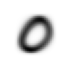

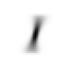

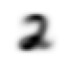

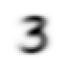

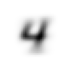

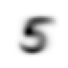

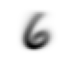

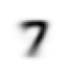

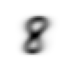

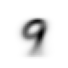

In [8]:
mean = [stacked_num.mean(0) for stacked_num in number_stacks]
for i in range(10):
    show_image(mean[i])

#### Try the loss for some number

In [9]:
for i in range(10):
    dist_abs = (number_stacks[3][1] - mean[i]).abs().mean()
    dist_sqr = ((number_stacks[3][1] - mean[i])**2).mean().sqrt()
    print("Abs. distance to " + str(i) + ":", dist_abs)
    print("Sqr. distance to " + str(i) + ":", dist_sqr)

Abs. distance to 0: tensor(0.1879)
Sqr. distance to 0: tensor(0.3203)
Abs. distance to 1: tensor(0.1353)
Sqr. distance to 1: tensor(0.2996)
Abs. distance to 2: tensor(0.1734)
Sqr. distance to 2: tensor(0.3023)
Abs. distance to 3: tensor(0.1114)
Sqr. distance to 3: tensor(0.2021)
Abs. distance to 4: tensor(0.1704)
Sqr. distance to 4: tensor(0.3142)
Abs. distance to 5: tensor(0.1443)
Sqr. distance to 5: tensor(0.2577)
Abs. distance to 6: tensor(0.1723)
Sqr. distance to 6: tensor(0.3103)
Abs. distance to 7: tensor(0.1586)
Sqr. distance to 7: tensor(0.3021)
Abs. distance to 8: tensor(0.1550)
Sqr. distance to 8: tensor(0.2791)
Abs. distance to 9: tensor(0.1601)
Sqr. distance to 9: tensor(0.3013)


#### More elegant version using pytorch

In [10]:
dist_abs = tensor([F.l1_loss(number_stacks[3][1], mean_num) for mean_num in mean])
dist_sqr = tensor([F.mse_loss(number_stacks[3][1], mean_num).sqrt() for mean_num in mean])
torch.argmin(dist_abs), torch.argmin(dist_sqr)

(tensor(3), tensor(3))

#### Define a metric and an identifier function

In [11]:
def l1_dist(a,b): return (a-b).abs().mean((-1,-2))

def l2_dist(a,b): return ((a-b)**2).mean((-1,-2)).sqrt()

def identify_abs(img):
    d_abs = torch.stack([l1_dist(img, mean_num) for mean_num in mean])
    return torch.min(d_abs, dim=0)[1], torch.min(d_abs, dim=0)[0]

def identify_sqr(img):
    d_sqr = torch.stack([l2_dist(img, mean_num) for mean_num in mean])
    return torch.min(d_sqr, dim=0)[1], torch.min(d_sqr, dim=0)[0]

def is_num_abs(img, number):
    return torch.eq(identify_abs(img)[0], number)

def is_num_sqr(img, number):
    return torch.eq(identify_sqr(img)[0], number)

#### Prepare validation Images

In [12]:
vnumber_stacks = [torch.stack([tensor(Image.open(zpath)).float()/255 for zpath in vnumber_list[i]]) for i in range(10)]
[stacked_num.shape for stacked_num in vnumber_stacks]

[torch.Size([980, 28, 28]),
 torch.Size([1135, 28, 28]),
 torch.Size([1032, 28, 28]),
 torch.Size([1010, 28, 28]),
 torch.Size([982, 28, 28]),
 torch.Size([892, 28, 28]),
 torch.Size([958, 28, 28]),
 torch.Size([1028, 28, 28]),
 torch.Size([974, 28, 28]),
 torch.Size([1009, 28, 28])]

#### Test validation Images

In [13]:

accuracy_abs = torch.stack([is_num_abs(vnumber_stacks[i], i).float().mean() for i in range(10)])
accuracy_sqr = torch.stack([is_num_sqr(vnumber_stacks[i], i).float().mean() for i in range(10)])
for i in range(10):
    print("Accuracy for " + str(i) +"s: ", accuracy_abs[i], " (abs),     ", accuracy_sqr[i], " (sqr)")
print("Accuracy overall: ", accuracy_abs.mean(), " (abs),     ", accuracy_sqr.mean(), " (sqr)")

Accuracy for 0s:  tensor(0.8153)  (abs),      tensor(0.8959)  (sqr)
Accuracy for 1s:  tensor(0.9982)  (abs),      tensor(0.9621)  (sqr)
Accuracy for 2s:  tensor(0.4234)  (abs),      tensor(0.7568)  (sqr)
Accuracy for 3s:  tensor(0.6089)  (abs),      tensor(0.8059)  (sqr)
Accuracy for 4s:  tensor(0.6680)  (abs),      tensor(0.8259)  (sqr)
Accuracy for 5s:  tensor(0.3262)  (abs),      tensor(0.6861)  (sqr)
Accuracy for 6s:  tensor(0.7871)  (abs),      tensor(0.8633)  (sqr)
Accuracy for 7s:  tensor(0.7646)  (abs),      tensor(0.8327)  (sqr)
Accuracy for 8s:  tensor(0.4425)  (abs),      tensor(0.7372)  (sqr)
Accuracy for 9s:  tensor(0.7760)  (abs),      tensor(0.8067)  (sqr)
Accuracy overall:  tensor(0.6610)  (abs),      tensor(0.8173)  (sqr)


## From scratch Neural Network

### Step 0: preparing the data

Preparing the data: 
Create a rank 2 tensor x with a vector of all pixels for each image and a rank 1 (technically rank 2) tensor y with the category for each image, then zip the into a Dataset usable by PyTorch.

In [14]:
train_x = torch.cat(number_stacks).view(-1,28*28)
train_y = torch.cat([tensor([i]*len(number_stacks[i])) for i in range(10)])
dset = list(zip(train_x, train_y))
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

Repeat for the validation set

In [15]:
valid_x = torch.cat(vnumber_stacks).view(-1,28*28)
valid_y = torch.cat([tensor([i]*len(vnumber_stacks[i])) for i in range(10)])
valid_dset = list(zip(valid_x, valid_y))

### Neural Network definition

Initialize weights and biases

In [16]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30, 10))
b2 = init_params(10)


First layer with 30 outputs

Take the ReLU of them -> Nonlinearity

Second layer with 10 outputs -> one for each possible category

In [17]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

### Loss function

In [18]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

In [19]:
def neg_log_smloss(sm_acts):
    torch.log(sm_acts)
    ret = [-sm_acts[i, train_y[i]] for i in range(len(train_y))]
    return tensor(ret)

In [20]:
sm = torch.softmax(simple_net(train_x),dim=1)
sm[0]

tensor([7.6654e-18, 1.0443e-33, 8.3852e-13, 9.8986e-26, 9.9906e-01, 2.2421e-44, 0.0000e+00, 3.5467e-11, 9.3508e-04, 3.2617e-10], grad_fn=<SelectBackward0>)

In [21]:
loss_func = nn.CrossEntropyLoss()
loss_func(simple_net(train_x), train_y)

tensor(60.6068, grad_fn=<NllLossBackward0>)

### Training

In [22]:
dl = DataLoader(dset, batch_size = 2048)
valid_dl = DataLoader(valid_dset, batch_size=2048)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([2048, 784]), torch.Size([2048]))

In [23]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.sum().backward()

def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.data.zero_()

def batch_accuracy(xb, yb):
    preds = torch.softmax(xb,dim=1)
    correct = torch.eq(torch.max(preds, dim=1)[1], yb)
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 14)


In [24]:
validate_epoch(simple_net)

0.13320484757423

In [25]:
lr = 0.25
params = w1,b1,w2,b2
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,10), opt_func=SGD,
                loss_func=loss_func, metrics=batch_accuracy)

In [26]:
#learn.fit(40, 0.1)

In [39]:
simple_net_pt = nn.Sequential(
    nn.Linear(28*28,10000),
    nn.ReLU(),
    #nn.Linear(20,20),
    #nn.ReLU(),
    nn.Linear(10000,10)
)

In [40]:
learn = Learner(dls, simple_net_pt, opt_func=SGD,
                loss_func=loss_func, metrics=batch_accuracy)

learn.fit(100, 0.25)

epoch,train_loss,valid_loss,batch_accuracy,time
0,2.032501,4.647899,0.101600,00:07
1,1.427047,2.692341,0.223200,00:07
2,1.015208,2.130095,0.365600,00:07
3,0.781385,1.809144,0.438300,00:07
4,0.646343,1.597564,0.478200,00:07
5,0.563505,1.411030,0.514200,00:06
6,0.510067,1.253249,0.550500,00:07
7,0.471857,1.108827,0.585800,00:07
8,0.441397,0.980537,0.626100,00:07
9,0.415324,0.867717,0.662700,00:07


In [42]:

x,y = dls.one_batch()
preds,_ = learn.get_preds(dl=[(x,y)])
print(y[-1])
torch.softmax(preds[-1],dim=-1)

tensor(0)


tensor([9.9993e-01, 6.7038e-07, 5.3819e-06, 7.0435e-08, 7.9705e-08, 6.6642e-06, 1.0869e-05, 4.7122e-05, 1.4007e-07, 1.2116e-06])

In [43]:
learn.export()

AttributeError: 'list' object has no attribute 'new_empty'

## PyTorch / FastAI Neural Network